In [1]:
from tqdm import tqdm
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft
from ava.models.vae_dataset import get_syllable_partition
from ava.models.vae_dataset import get_syllable_data_loaders

In [2]:
# days = [36, 37, 38, 39, 40, 138, 139, 140]
days = [36, 37, 38, 139, 140]
spec_dirs = ['../audio_spec/%d' % _ for _ in days]
clip_dirs = ['../audio_clips/%d' % _ for _ in days]

In [3]:
split = 0.8 # 80/20 train/test split

# Construct a random train/test partition.
partition = get_syllable_partition(spec_dirs, split)
# partition = get_syllable_partition(clip_dirs, split)

# Make Dataloaders.
loaders = get_syllable_data_loaders(partition, batch_size=128)

In [4]:
len(loaders['train'])

454

In [5]:
for i, spec in enumerate(loaders['test']):
    # spec = spec[:,:,5:-5]
    print(spec.shape)
    break # just to get a slice
sample = spec.numpy()

Traceback (most recent call last):
  File "/usr/lib64/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib64/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib64/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib64/python3.10/shutil.py", line 731, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib64/python3.10/shutil.py", line 729, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-ibrqn6gf'


torch.Size([128, 50, 20])


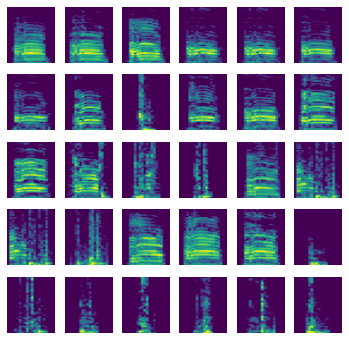

In [6]:
%matplotlib inline
fig, ax = plt.subplots(5, 6, figsize=(6,6), sharex='all', sharey='all')
ax = ax.flatten()
for i in range(len(ax)):
    ax[i].imshow(sample[i], aspect='auto', origin='lower')
    # # ax[i].plot(sample[i].numpy())
    # f, t, sxx = stft(sample[i].numpy(), fs=8820, nperseg=128, noverlap=64)
    # sxx = np.log(np.abs(sxx) + 1e-12)
    # sxx = (sxx - 3) / 5
    # sxx = np.clip(sxx, 0, 1)
    # ax[i].imshow(sxx, aspect='auto')
    ax[i].set_axis_off()
plt.show()

In [7]:
act_func = lambda x: torch.log(1+x**2)
# act_func = lambda x: torch.tanh(x)
class audioNet(nn.Module):
    def __init__(self, spec_dims, output_dim):
        super(audioNet, self).__init__()
        self.w1 = nn.Linear(np.prod(spec_dims), output_dim, bias=False)
        # self.w2 = nn.Linear(400, output_dim, bias=False)
        
    def forward(self, x):
        if len(x.shape) > 2:
            x = torch.flatten(x, start_dim=1) # first dim is batch
        y = act_func(self.w1(x))
        # y = act_func(self.w2(y))
        return y

In [8]:
net = audioNet(sample.shape[1:], 100)
# optimizer = torch.optim.SGD(net.parameters(), lr=1e-2, weight_decay=1e-5)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-5)

EPOCH = 25
train_loss, test_loss = [], []

In [9]:
def loss_func(out):
    L2_sample = torch.sqrt((out**2).sum(dim=0, keepdim=True))
    out = out / L2_sample
    L2_feature = torch.sqrt((out**2).sum(dim=1, keepdim=True))
    out = out / L2_feature
    L1_all = torch.abs(out).mean()
    return L1_all

In [10]:
for epoch in range(EPOCH):
    aux_train_loss = []
    for spec in tqdm(loaders['train']):
        # spec = spec[:,:,5:-5]
        spec += torch.normal(0, 0.05, size=spec.shape)
        spec = (spec - spec.mean(dim=(1,2), keepdim=True))
        optimizer.zero_grad()
        out = net(spec)
        loss = loss_func(out)
        
        aux_train_loss.append(loss.item())
        
        loss.backward()
        optimizer.step()
    
    train_loss.append(aux_train_loss)
    
    with torch.no_grad():
        aux_test_loss = []
        for i, spec in enumerate(loaders['test']):
            # spec = spec[:,:,5:-5]
            spec = (spec - spec.mean(dim=(1,2), keepdim=True))
            # spec = (spec - spec.mean(dim=(1,2), keepdim=True)) \
            #      / spec.std(dim=(1,2), keepdim=True)
            if i > 50:
                break
            out = net(spec)
            loss = loss_func(out)
            aux_test_loss.append(loss.item())
        test_loss.append(aux_test_loss)
    
    print('[%d] Train loss = %.3E, Test loss = %.3E' % \
          (epoch, np.mean(aux_train_loss), np.mean(aux_test_loss)))

100%|█████████████████████████████████████████| 454/454 [00:04<00:00, 96.36it/s]


[0] Train loss = 4.078E-02, Test loss = 3.753E-02


100%|█████████████████████████████████████████| 454/454 [00:04<00:00, 92.06it/s]


[1] Train loss = 3.110E-02, Test loss = 3.487E-02


100%|█████████████████████████████████████████| 454/454 [00:04<00:00, 91.07it/s]


[2] Train loss = 2.854E-02, Test loss = 3.368E-02


100%|█████████████████████████████████████████| 454/454 [00:05<00:00, 89.06it/s]


[3] Train loss = 2.725E-02, Test loss = 3.267E-02


100%|█████████████████████████████████████████| 454/454 [00:04<00:00, 91.11it/s]


[4] Train loss = 2.617E-02, Test loss = 3.240E-02


100%|█████████████████████████████████████████| 454/454 [00:04<00:00, 91.14it/s]


[5] Train loss = 2.552E-02, Test loss = 3.190E-02


100%|█████████████████████████████████████████| 454/454 [00:05<00:00, 87.94it/s]


[6] Train loss = 2.483E-02, Test loss = 3.181E-02


100%|█████████████████████████████████████████| 454/454 [00:05<00:00, 90.37it/s]


[7] Train loss = 2.431E-02, Test loss = 3.143E-02


100%|█████████████████████████████████████████| 454/454 [00:05<00:00, 90.42it/s]


[8] Train loss = 2.415E-02, Test loss = 3.157E-02


100%|█████████████████████████████████████████| 454/454 [00:05<00:00, 86.70it/s]


[9] Train loss = 2.398E-02, Test loss = 3.100E-02


100%|█████████████████████████████████████████| 454/454 [00:05<00:00, 87.41it/s]


[10] Train loss = 2.360E-02, Test loss = 3.080E-02


100%|█████████████████████████████████████████| 454/454 [00:05<00:00, 88.82it/s]


[11] Train loss = 2.340E-02, Test loss = 3.125E-02


100%|█████████████████████████████████████████| 454/454 [00:04<00:00, 91.38it/s]


[12] Train loss = 2.331E-02, Test loss = 3.081E-02


100%|█████████████████████████████████████████| 454/454 [00:05<00:00, 90.59it/s]


[13] Train loss = 2.356E-02, Test loss = 2.992E-02


100%|█████████████████████████████████████████| 454/454 [00:05<00:00, 89.30it/s]


[14] Train loss = 2.344E-02, Test loss = 3.014E-02


100%|█████████████████████████████████████████| 454/454 [00:05<00:00, 90.12it/s]


[15] Train loss = 2.339E-02, Test loss = 2.959E-02


100%|█████████████████████████████████████████| 454/454 [00:05<00:00, 84.85it/s]


[16] Train loss = 2.291E-02, Test loss = 3.068E-02


100%|█████████████████████████████████████████| 454/454 [00:04<00:00, 91.85it/s]


[17] Train loss = 2.310E-02, Test loss = 3.015E-02


100%|█████████████████████████████████████████| 454/454 [00:04<00:00, 92.32it/s]


[18] Train loss = 2.297E-02, Test loss = 3.027E-02


100%|█████████████████████████████████████████| 454/454 [00:04<00:00, 91.07it/s]


[19] Train loss = 2.292E-02, Test loss = 3.027E-02


100%|█████████████████████████████████████████| 454/454 [00:04<00:00, 92.70it/s]


[20] Train loss = 2.282E-02, Test loss = 3.025E-02


100%|█████████████████████████████████████████| 454/454 [00:04<00:00, 91.16it/s]


[21] Train loss = 2.301E-02, Test loss = 2.913E-02


100%|█████████████████████████████████████████| 454/454 [00:04<00:00, 90.88it/s]


[22] Train loss = 2.285E-02, Test loss = 3.007E-02


100%|█████████████████████████████████████████| 454/454 [00:04<00:00, 92.47it/s]


[23] Train loss = 2.301E-02, Test loss = 2.926E-02


100%|█████████████████████████████████████████| 454/454 [00:04<00:00, 91.84it/s]


[24] Train loss = 2.259E-02, Test loss = 3.013E-02


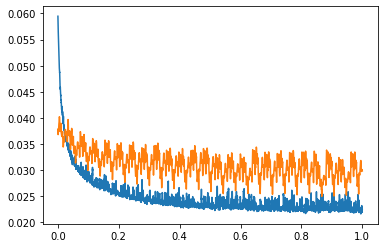

In [11]:
%matplotlib inline
train_loss, test_loss = np.hstack(train_loss), np.hstack(test_loss)
train_loss = np.convolve(train_loss, np.ones(10)/10)[11:-11]
test_loss = np.convolve(test_loss, np.ones(10)/10)[11:-11]
plt.plot(np.linspace(0,1,num=len(train_loss)), train_loss)
plt.plot(np.linspace(0,1,num=len(test_loss)), test_loss)

In [12]:
torch.save(net.state_dict(), 'net_params.pkl')

In [13]:
# %matplotlib inline
# f, t, sxx = stft(spec[i].numpy(), fs=8820, nperseg=128, noverlap=64)
# sxx = np.log(np.abs(sxx) + 1e-12)
# sxx = (sxx - 3) / 5
# sxx = np.clip(sxx, 0, 1)
# plt.imshow(sxx)
# plt.colorbar()
# plt.show()

-0.11675093 0.14153174


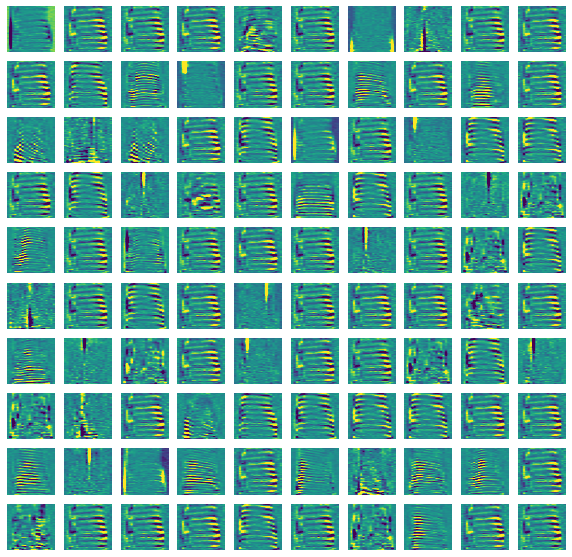

In [14]:
%matplotlib inline
fig, ax = plt.subplots(10, 10, figsize=(10,10), sharex='all', sharey='all')
ax = ax.flatten()
w1 = net.w1.weight.data.numpy()
print(w1.min(), w1.max())
w1 = (w1 - w1.mean(axis=1)[:,None]) / w1.std(axis=1)[:,None]
for i in range(len(ax)):
    ax[i].imshow(w1[i].reshape(sample.shape[1:]), vmin=-2, vmax=2, 
                 aspect='auto', origin='lower')
    ax[i].set_axis_off()
plt.show()

tensor(0.0483)

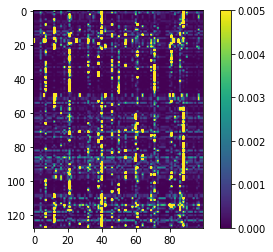

In [15]:
y = net(torch.tensor(sample - sample.mean(axis=(1,2),keepdims=True))).detach()
plt.imshow(y.numpy(), vmin=0, vmax=0.005)
plt.colorbar()
loss_func(y)

In [16]:
# %matplotlib inline
# fig, ax = plt.subplots(5, 6, figsize=(10,10), sharex='all', sharey='all')
# ax = ax.flatten()
# w2 = net.w2.weight.data.numpy()
# w = w2 @ w1
# for i in range(len(ax)):
#     ax[i].imshow(w[i].reshape((64,32)), aspect='auto')
#     ax[i].set_axis_off()
# plt.show()